# Contexted data description

Here is performed some aditional descriptions, focus on the problem context for traffic flow

In [1]:
#LOADS LIBRARIES
import os
import sys
import warnings
warnings.simplefilter('ignore')
import pickle
#import dill as pickle

import numpy as np
import pandas as pd
import math

import time 
import datetime
from dateutil.relativedelta import relativedelta

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
#sns.reset_orig
#matplotlib.rc_file_defaults()

In [51]:
import geopy.distance
#!pip install geopy

In [3]:
# Defines the storage directories
OUTPUT_DIR = os.getcwd() + '/results/'

# Data context

In [4]:
#Call the analysis data frame

df_analysis = pd.read_pickle(OUTPUT_DIR + 'df_vhf_s2.pkl')

print(df_analysis.shape)
print('\n')

for c in df_analysis.columns.tolist():
    print(c)

(186905, 11)


mes,_dã­a,_aã±o_de_h_fecha
aut_nombre
disp_nombre
seccion_sentido
h_hora
disp_ubicacion
disp_lat
disp_lng
h_cant_veh
mes
dia_semana


In [118]:
df_obs = df_analysis[
    (df_analysis['disp_nombre']=='RD100 MONTIEL')
    &(df_analysis['seccion_sentido']=='A')
    &(df_analysis['mes']==3)
    &(df_analysis['dia_semana']==0)
    &(df_analysis['h_hora']==0)
]

df_obs

,"mes,_dã­a,_aã±o_de_h_fecha",aut_nombre,disp_nombre,seccion_sentido,h_hora,disp_ubicacion,disp_lat,disp_lng,h_cant_veh,mes,dia_semana
101531,2021-03-01,AU DELLEPIANE,RD100 MONTIEL,A,0.0,0.4,-34.68411,-58.48264,1638.0,3,0
101865,2021-03-08,AU DELLEPIANE,RD100 MONTIEL,A,0.0,0.4,-34.68411,-58.48264,1462.0,3,0
102201,2021-03-15,AU DELLEPIANE,RD100 MONTIEL,A,0.0,0.4,-34.68411,-58.48264,1273.0,3,0
102537,2021-03-22,AU DELLEPIANE,RD100 MONTIEL,A,0.0,0.4,-34.68411,-58.48264,1026.0,3,0


In [117]:
#Summarizing the traffic flow by hours

df_meanflow = df_analysis.groupby(['disp_nombre','seccion_sentido','mes','dia_semana','h_hora']).agg(
    disp_lat = ('disp_lat','max'),
    disp_lng = ('disp_lng','max'),
    q_prom = ('h_cant_veh','mean'),
    nro_obs = ('h_cant_veh','count')
)

df_meanflow = df_meanflow.reset_index().copy()
df_meanflow['q_prom'] = round(df_meanflow['q_prom']).astype('int')

df_meanflow

,disp_nombre,seccion_sentido,mes,dia_semana,h_hora,disp_lat,disp_lng,q_prom,nro_obs
0,RD100 MONTIEL,A,3,0,0.0,-34.68411,-58.48264,1350,4
1,RD100 MONTIEL,A,3,0,1.0,-34.68411,-58.48264,689,4
2,RD100 MONTIEL,A,3,0,2.0,-34.68411,-58.48264,523,4
3,RD100 MONTIEL,A,3,0,3.0,-34.68411,-58.48264,479,4
4,RD100 MONTIEL,A,3,0,4.0,-34.68411,-58.48264,1201,4
...,...,...,...,...,...,...,...,...,...
46989,RD183 CENTRO NAVAL,B,11,6,19.0,-34.53709,-58.45916,4184,3
46990,RD183 CENTRO NAVAL,B,11,6,20.0,-34.53709,-58.45916,4090,3
46991,RD183 CENTRO NAVAL,B,11,6,21.0,-34.53709,-58.45916,3426,3
46992,RD183 CENTRO NAVAL,B,11,6,22.0,-34.53709,-58.45916,3456,3


In [62]:
#Select a traffic orientation

df_meanflowA = df_meanflow[df_meanflow['seccion_sentido']=='A'].copy()
df_meanflowA

,disp_nombre,seccion_sentido,mes,dia_semana,h_hora,disp_lat,disp_lng,q_prom
0,RD100 MONTIEL,A,3,0,0.0,-34.68411,-58.48264,1350
1,RD100 MONTIEL,A,3,0,1.0,-34.68411,-58.48264,689
2,RD100 MONTIEL,A,3,0,2.0,-34.68411,-58.48264,523
3,RD100 MONTIEL,A,3,0,3.0,-34.68411,-58.48264,479
4,RD100 MONTIEL,A,3,0,4.0,-34.68411,-58.48264,1201
...,...,...,...,...,...,...,...,...
40941,RD171 ESMA,A,11,6,19.0,-34.53767,-58.45967,6577
40942,RD171 ESMA,A,11,6,20.0,-34.53767,-58.45967,6279
40943,RD171 ESMA,A,11,6,21.0,-34.53767,-58.45967,5467
40944,RD171 ESMA,A,11,6,22.0,-34.53767,-58.45967,4188


In [63]:
#Stalishes the amount of radars

df_radarsA = df_meanflowA.groupby(['disp_nombre']).agg(
    disp_lat = ('disp_lat','max'),
    disp_lng = ('disp_lng','max'),
    counts = ('q_prom','count')
)

df_radarsA = df_radarsA.reset_index()
df_radarsA = df_radarsA.reset_index()
df_radarsA = df_radarsA.rename(columns={'index':'radar_order'})

df_radarsA

,radar_order,disp_nombre,disp_lat,disp_lng,counts
0,0,RD100 MONTIEL,-34.68411,-58.48264,1512
1,1,RD101 DE LA TORRE,-34.67917,-58.47959,1008
2,2,RD103 MIRALLA,-34.66990,-58.47536,1512
3,3,RD105 HOMERO,-34.66044,-58.47124,274
4,4,RD106 ZINNY,-34.65465,-58.46901,1344
5,5,RD108 RAMAL A 27F.,-34.65369,-58.46812,1512
6,6,RD113 INGRESO DELL2,-34.65134,-58.46643,504
7,7,RD125 OSV.CRUZ A,-34.65134,-58.37255,1512
8,8,RD127 BEN.Q.MARTÃ­N A,-34.64357,-58.37568,1344
9,9,RD130 SUAREZ,-34.63940,-58.37635,1512


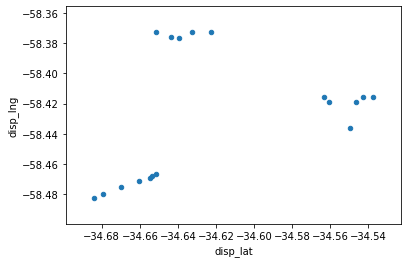

In [64]:
df_data = df_radarsA[['disp_lat','disp_lng']]
df_data.plot.scatter(x='disp_lat',y='disp_lng')

In [108]:
#Estimates distance between radars

df_radarsA['disp_lat_m1'] = df_radarsA['disp_lat'].shift(1)
df_radarsA['disp_lng_m1'] = df_radarsA['disp_lng'].shift(1)

def distance(x):
    
    coords_1 = (x['disp_lat'], x['disp_lng'])
    coords_2 = (x['disp_lat_m1'], x['disp_lng_m1'])
    
    try:
        y =  geopy.distance.geodesic(coords_1, coords_2).km
    except:
        y = 0
        
    return y

df_radarsA['distance'] = df_radarsA.apply(lambda x: distance(x), axis=1)

mean_distance = df_radarsA['distance'].sum() / len(df_radarsA)

df_radarsA.loc[df_radarsA['distance']==0,'distance']=mean_distance


df_radarsA

,radar_order,disp_nombre,disp_lat,disp_lng,counts,disp_lat_m1,disp_lng_m1,distance
0,0,RD100 MONTIEL,-34.68411,-58.48264,1512,NaN,NaN,1.590730
1,1,RD101 DE LA TORRE,-34.67917,-58.47959,1008,-34.68411,-58.48264,0.615179
2,2,RD103 MIRALLA,-34.66990,-58.47536,1512,-34.67917,-58.47959,1.099009
3,3,RD105 HOMERO,-34.66044,-58.47124,274,-34.66990,-58.47536,1.115316
4,4,RD106 ZINNY,-34.65465,-58.46901,1344,-34.66044,-58.47124,0.674053
5,5,RD108 RAMAL A 27F.,-34.65369,-58.46812,1512,-34.65465,-58.46901,0.134157
6,6,RD113 INGRESO DELL2,-34.65134,-58.46643,504,-34.65369,-58.46812,0.303256
7,7,RD125 OSV.CRUZ A,-34.65134,-58.37255,1512,-34.65134,-58.46643,8.606326
8,8,RD127 BEN.Q.MARTÃ­N A,-34.64357,-58.37568,1344,-34.65134,-58.37255,0.908468
9,9,RD130 SUAREZ,-34.63940,-58.37635,1512,-34.64357,-58.37568,0.466656


In [109]:
df_meanflowA_01 = pd.merge(df_meanflowA,
                          df_radarsA[['disp_nombre','radar_order','distance']],
                          on=['disp_nombre'],
                          how='left').copy()

print(df_meanflowA_01.shape)
df_meanflowA_01

(23200, 10)


,disp_nombre,seccion_sentido,mes,dia_semana,h_hora,disp_lat,disp_lng,q_prom,radar_order,distance
0,RD100 MONTIEL,A,3,0,0.0,-34.68411,-58.48264,1350,0,1.590730
1,RD100 MONTIEL,A,3,0,1.0,-34.68411,-58.48264,689,0,1.590730
2,RD100 MONTIEL,A,3,0,2.0,-34.68411,-58.48264,523,0,1.590730
3,RD100 MONTIEL,A,3,0,3.0,-34.68411,-58.48264,479,0,1.590730
4,RD100 MONTIEL,A,3,0,4.0,-34.68411,-58.48264,1201,0,1.590730
...,...,...,...,...,...,...,...,...,...,...
23195,RD171 ESMA,A,11,6,19.0,-34.53767,-58.45967,6577,17,0.583503
23196,RD171 ESMA,A,11,6,20.0,-34.53767,-58.45967,6279,17,0.583503
23197,RD171 ESMA,A,11,6,21.0,-34.53767,-58.45967,5467,17,0.583503
23198,RD171 ESMA,A,11,6,22.0,-34.53767,-58.45967,4188,17,0.583503


In [124]:
df_months = df_analysis['mes'].value_counts(dropna=False).reset_index().sort_values(['index'])
ls_months = df_months['index'].tolist()

df_weekdays = df_analysis['dia_semana'].value_counts(dropna=False).reset_index().sort_values(['index'])
ls_weekdays = df_weekdays['index'].tolist()

df_hours = df_analysis['h_hora'].value_counts(dropna=False).reset_index().sort_values(['index'])
ls_hours = df_hours['index'].tolist()
ls_hours

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0]

In [126]:
#Computes the average spacing and velocity


for m in ls_months:
    for d in ls_weekdays:
        for h in ls_hours:
            
            df_meanflowA_filtered = df_meanflowA_01[
                (df_meanflowA_01['mes']==m)
                &(df_meanflowA_01['dia_semana']==d)
            ]

            df_meanflowA_filtered

            df_meanflowA_filtered_02 = df_meanflowA_filtered[df_meanflowA_filtered['h_hora']==h].copy()
            #print(df_meanflowA_filtered_02.shape)

            TT_distance = sum(df_radarsA['distance'])
            TT_distance

            mean_vehicules = df_meanflowA_filtered_02['q_prom'].sum()/len(df_meanflowA_filtered_02)
            mean_vehicules

            spacing = TT_distance/mean_vehicules
            spacing #km/vh

            df_meanflowA_filtered_02['mean_vehicules_city'] = mean_vehicules
            df_meanflowA_filtered_02['spacing'] =  df_meanflowA_filtered_02['distance'] / df_meanflowA_filtered_02['q_prom']
            df_meanflowA_filtered_02['v_prom'] = df_meanflowA_filtered_02['mean_vehicules_city']*df_meanflowA_filtered_02['spacing']
            df_meanflowA_filtered_02
            
            if (m==ls_months[0]) & (d==ls_weekdays[0]) & (h==ls_hours[0]):
                df_meanflowA_filtered_03 = df_meanflowA_filtered_02.copy()
            else:
                df_meanflowA_filtered_03 = df_meanflowA_filtered_03.append(df_meanflowA_filtered_02).copy()

df_meanflowA_filtered_03 = df_meanflowA_filtered_03.reset_index(drop=True)
print(df_meanflowA_filtered_03.shape)
df_meanflowA_filtered_03

(23200, 13)


,disp_nombre,seccion_sentido,mes,dia_semana,h_hora,disp_lat,disp_lng,q_prom,radar_order,distance,mean_vehicules_city,spacing,v_prom
0,RD100 MONTIEL,A,3,0,0.0,-34.68411,-58.48264,1350,0,1.590730,1154.466667,0.001178,1.360329
1512,RD101 DE LA TORRE,A,3,0,0.0,-34.67917,-58.47959,1237,1,0.615179,1154.466667,0.000497,0.574134
2520,RD103 MIRALLA,A,3,0,0.0,-34.66990,-58.47536,1461,2,1.099009,1154.466667,0.000752,0.868426
4306,RD106 ZINNY,A,3,0,0.0,-34.65465,-58.46901,1108,4,0.674053,1154.466667,0.000608,0.702322
5650,RD108 RAMAL A 27F.,A,3,0,0.0,-34.65369,-58.46812,317,5,0.134157,1154.466667,0.000423,0.488578
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17151,RD166 OMBUES,A,11,6,23.0,-34.56044,-58.41908,3242,13,0.475292,2123.266667,0.000147,0.311280
18663,RD168 JURAMENTO,A,11,6,23.0,-34.54977,-58.43602,3169,14,1.954036,2123.266667,0.000617,1.309227
20175,RD169 MONROE,A,11,6,23.0,-34.54629,-58.44224,3574,15,1.602083,2123.266667,0.000448,0.951777
21687,RD170 UDAONDO,A,11,6,23.0,-34.54293,-58.44901,3470,16,0.509858,2123.266667,0.000147,0.311978


In [153]:
df_meanflowA_filtered_04 = df_meanflowA_filtered_03[
                (df_meanflowA_filtered_03['mes']==11)
                &(df_meanflowA_filtered_03['dia_semana']==0)
            ]

df_meanflowA_filtered_04

,disp_nombre,seccion_sentido,mes,dia_semana,h_hora,disp_lat,disp_lng,q_prom,radar_order,distance,mean_vehicules_city,spacing,v_prom
20619,RD100 MONTIEL,A,11,0,0.0,-34.68411,-58.48264,1311,0,1.590730,1445.933333,0.001213,1.754454
20620,RD101 DE LA TORRE,A,11,0,0.0,-34.67917,-58.47959,1271,1,0.615179,1445.933333,0.000484,0.699849
20621,RD103 MIRALLA,A,11,0,0.0,-34.66990,-58.47536,1578,2,1.099009,1445.933333,0.000696,1.007031
20622,RD106 ZINNY,A,11,0,0.0,-34.65465,-58.46901,1158,4,0.674053,1445.933333,0.000582,0.841655
20623,RD108 RAMAL A 27F.,A,11,0,0.0,-34.65369,-58.46812,312,5,0.134157,1445.933333,0.000430,0.621736
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20974,RD166 OMBUES,A,11,0,23.0,-34.56044,-58.41908,2434,13,0.475292,1598.666667,0.000195,0.312175
20975,RD168 JURAMENTO,A,11,0,23.0,-34.54977,-58.43602,2435,14,1.954036,1598.666667,0.000802,1.282896
20976,RD169 MONROE,A,11,0,23.0,-34.54629,-58.44224,2703,15,1.602083,1598.666667,0.000593,0.947539
20977,RD170 UDAONDO,A,11,0,23.0,-34.54293,-58.44901,2595,16,0.509858,1598.666667,0.000196,0.314102


In [154]:
df_meanflowA_filtered_05 = pd.pivot_table(df_meanflowA_filtered_04,index=['radar_order'],columns=['h_hora'],values='q_prom',aggfunc='max')
v_velocities = df_meanflowA_filtered_05.values

df_meanflowA_filtered_05 = df_meanflowA_filtered_05.reset_index()


df_meanflowA_filtered_05 = pd.merge(df_meanflowA_filtered_05,
                          df_radarsA[['disp_nombre','radar_order','distance']],
                          on=['radar_order'],
                          how='left').copy()

df_meanflowA_filtered_05

,radar_order,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,disp_nombre,distance
0,0,1311,844,593,547,1072,3031,4354,4408,4502,...,3959,4030,3606,3710,3264,2751,2049,1443,RD100 MONTIEL,1.590730
1,1,1271,830,586,539,1010,2939,4250,3941,4045,...,4026,4076,3648,3745,3292,2760,2050,1445,RD101 DE LA TORRE,0.615179
2,2,1578,1062,726,617,1029,2810,4275,4376,4806,...,4860,4606,4310,4272,3821,3185,2444,1671,RD103 MIRALLA,1.099009
3,4,1158,778,525,459,877,2413,3496,3508,3857,...,3664,3691,3264,3221,2866,2437,1827,1343,RD106 ZINNY,0.674053
4,5,312,222,122,154,253,619,780,617,729,...,820,800,714,768,772,662,522,369,RD108 RAMAL A 27F.,0.134157
5,6,18,10,11,4,7,22,51,87,133,...,64,59,48,57,48,32,33,21,RD113 INGRESO DELL2,0.303256
6,7,833,582,423,426,671,1782,2712,3328,2518,...,2304,2365,2221,2101,2005,2150,1207,884,RD125 OSV.CRUZ A,8.606326
7,9,898,621,446,432,689,1868,2984,3732,3225,...,2695,2787,2505,2326,2203,2467,1295,940,RD130 SUAREZ,0.466656
8,10,948,639,456,397,596,1656,2718,3581,3587,...,3024,3071,2683,2438,2287,2472,1339,963,RD134 ITUZAINGO,0.826751
9,12,1894,1172,788,621,766,1814,3589,5614,6202,...,5788,5772,5841,4478,4013,3150,2423,2129,RD165 DORREGO,7.668666


In [160]:
ls_radars = df_meanflowA_filtered_05['disp_nombre'].tolist()
ls_radars

df_hours = df_meanflowA_filtered_04['h_hora'].value_counts(dropna=False).reset_index().sort_values(['index'])
ls_hours = df_hours['index'].tolist()
ls_hours

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0]

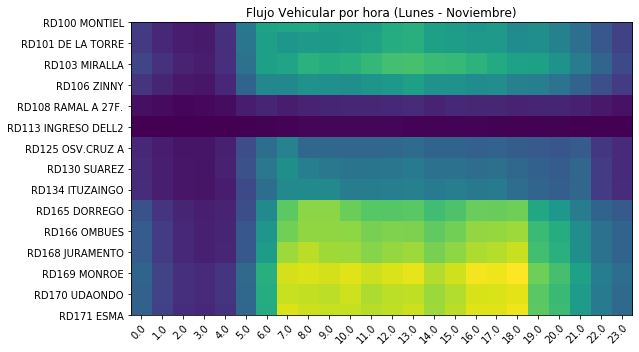

In [161]:
fig, ax = plt.subplots(figsize=(15, 5))
im = ax.imshow(v_velocities)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(ls_hours)))
ax.set_yticks(np.arange(len(ls_radars)))

ax.set_xticklabels(ls_hours)
ax.set_yticklabels(ls_radars)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
#for i in range(len(ls_hours)):
#    for j in range(len(ls_radars)):
#        text = ax.text(j, i, v_velocities[i, j],
#                       ha="center", va="center", color="w")

ax.set_title("Flujo Vehicular por hora (Lunes - Noviembre)")
fig.tight_layout()
plt.show()